In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb


In [ ]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: phucdhse184737 (daiphat2312-fpt-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
import pandas as pd
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
cd /content/drive/MyDrive/DAT/Assignment/

/content/drive/MyDrive/DAT/Assignment


In [ ]:
train = pd.read_csv('train.tsv', delimiter='\t',header=None)
dev = pd.read_csv('dev.tsv', delimiter='\t', header=None)
test = pd.read_csv('test.tsv', delimiter='\t', header=None)

columns = ['text', 'labels', 'id']

train.columns = columns
dev.columns = columns
test.columns = columns

In [ ]:
train.drop('id', axis=1, inplace=True)
dev.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [ ]:
train.head()

,text,labels
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
emotion_list = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

ekman_mapping = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness", "confusion"],
    "joy": ["admiration", "amusement", "approval", "caring", "desire", "excitement",
            "gratitude", "joy", "love", "optimism", "pride", "relief"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    "surprise": ["surprise", "realization", "curiosity"],
    "neutral": ["neutral"]
}

ekman_to_index = {k: i for i, k in enumerate(ekman_mapping.keys())}


In [ ]:
def map_labels(labels):
    new_id_label = []
    emotions = labels.split(',')
    for label in emotions:
        label = emotion_list[int(label)]
        new_label = [ekman_to_index[k] for k, v in ekman_mapping.items() if label in v]
        new_id_label.extend(new_label)
    return list(set(new_id_label))

In [ ]:
train['new_labels'] = train['labels'].apply(map_labels)
dev['new_labels'] = dev['labels'].apply(map_labels)
test['new_labels'] = test['labels'].apply(map_labels)

In [ ]:
train.shape

(43410, 3)

In [ ]:
train.sample(15)

,text,labels,new_labels
6634,> The frothing at the mouth over the Primary A...,27,[6]
27797,They didn’t take it; you abandoned it. A TSA a...,20,[3]
1925,I almost wanted to ask him if it was worth it ...,27,[6]
29001,Go off [NAME] This season has been a roller co...,0,[3]
37270,> I guess you don't agree Did *you* read *my* ...,6,[2]
31793,If that’s what I saw when I was on the brink i...,27,[6]
41499,U gotta work hard to get those virgins son.,0,[3]
3621,And our bishops will take his side. We're surr...,27,[6]
5204,"Well, I’ll be here when you fail!",5,[3]
40650,"After reading this comment, I wholeheartedly h...",20,[3]


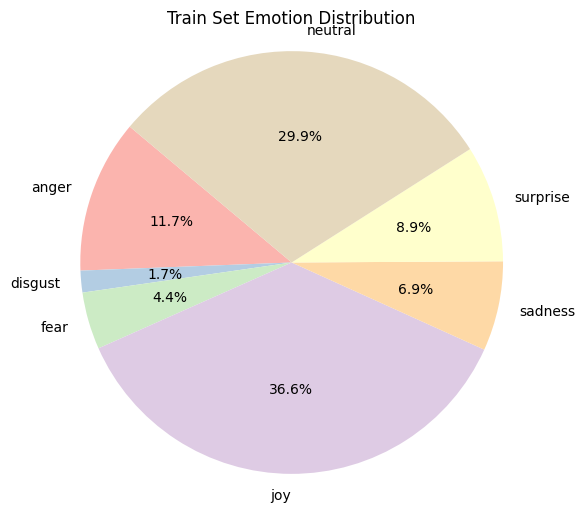

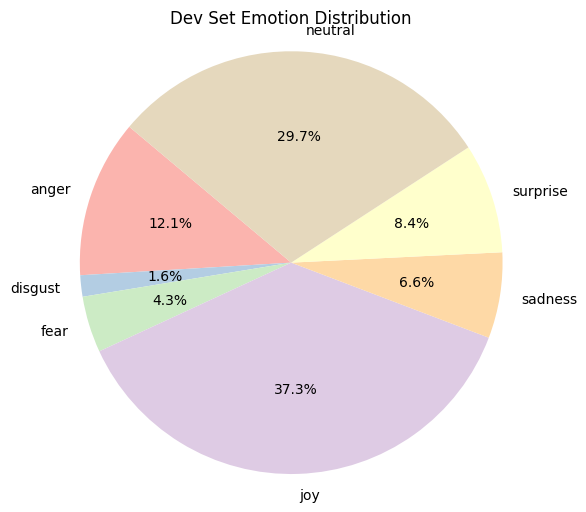

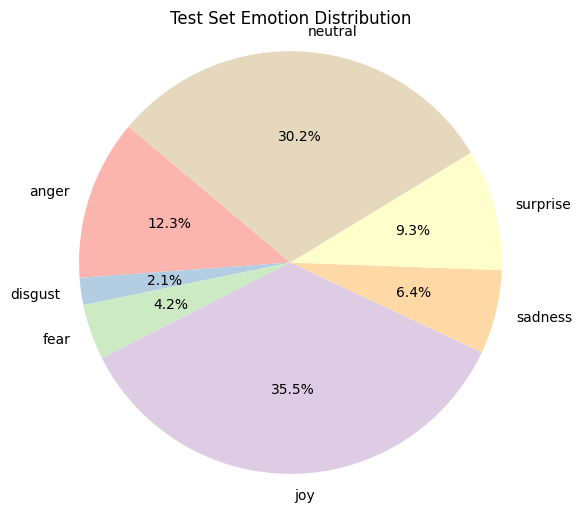

In [ ]:
def count_labels(df):
    flat_labels = [label for sublist in df['new_labels'] for label in sublist]
    counter = Counter(flat_labels)
    return dict(sorted(counter.items()))

index_to_ekman = {v: k for k, v in ekman_to_index.items()}

def plot_pie(label_counts, title):
    labels = [index_to_ekman[i] for i in label_counts.keys()]
    sizes = list(label_counts.values())
    colors = plt.cm.Pastel1.colors

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title(title)
    plt.show()

train_counts = count_labels(train)
dev_counts = count_labels(dev)
test_counts = count_labels(test)
plot_pie(train_counts, "Train Set Emotion Distribution")
plot_pie(dev_counts, "Dev Set Emotion Distribution")
plot_pie(test_counts, "Test Set Emotion Distribution")

In [ ]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s!?.,']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train['text'] = train['text'].apply(clean_text)
dev['text'] = dev['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)


In [ ]:
mlb = MultiLabelBinarizer(classes=list(range(7)))
y_train = mlb.fit_transform(train['new_labels'])
y_dev = mlb.transform(dev['new_labels'])
y_test = mlb.transform(test['new_labels'])


In [ ]:
train.head()

,text,labels,new_labels
0,my favourite food is anything i didn't have to...,27,[6]
1,"now if he does off himself, everyone will thin...",27,[6]
2,why the fuck is bayless isoing,2,[0]
3,to make her feel threatened,14,[2]
4,dirty southern wankers,3,[0]


In [ ]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2), max_df=0.9, min_df=3)
x_train = tfidf.fit_transform(train['text'])
x_dev = tfidf.transform(dev['text'])
X_test = tfidf.transform(test['text'])

In [ ]:
wandb.init(
    project="DAT_assignment",
    name="LR_tfidf_run1",
    config={
        "model": "Logistic Regression (Keras Dense)",
        "vectorizer": "TF-IDF",
        "input_dim": 10000,
        "output_dim": 7,
        "activation": "sigmoid",
        "optimizer": "adam",
        "learning_rate": 0.01,
        "epoch": 20,
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "batch_size": 64,
        "earlystop_patience": 7
    }
)
config = wandb.config


batch/accuracy,▁▁▂▂▂▂▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇███████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▆▇▇██
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▁▁
epoch/val_accuracy,▁▇███▆▆▅
epoch/val_loss,█▂▁▁▂▄▅▇
batch/accuracy,0.7224


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
model = Sequential([
    Input(shape=(config.input_dim,)),
    Dense(config.output_dim, activation=config.activation)
])

model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[config.metric]
)

early_stop = EarlyStopping(
    monitor='loss',
    patience=config.earlystop_patience,
    restore_best_weights=True
)

history = model.fit(
    x_train.toarray(), y_train,
    validation_data=(x_dev.toarray(), y_dev),
    epochs=config.epoch,
    batch_size=config.batch_size,
    callbacks=[
        WandbMetricsLogger(log_freq=5),
        WandbModelCheckpoint("models/model.keras"),
        early_stop

    ]
)


Epoch 1/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4583 - loss: 0.4345 - val_accuracy: 0.5695 - val_loss: 0.3024
Epoch 2/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6146 - loss: 0.2792 - val_accuracy: 0.5909 - val_loss: 0.2851
Epoch 3/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6539 - loss: 0.2478 - val_accuracy: 0.5971 - val_loss: 0.2805
Epoch 4/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6817 - loss: 0.2301 - val_accuracy: 0.5968 - val_loss: 0.2814
Epoch 5/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6972 - loss: 0.2172 - val_accuracy: 0.5982 - val_loss: 0.2844
Epoch 6/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7109 - loss: 0.2084 - val_accuracy: 0.5899 - val_loss: 0.2887
Epoch 7/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7197 - loss: 0.2009 - val_accuracy: 0.5890 - val_loss: 0.2938
Epoch 8/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7282 - loss: 0.1953 - val_accuracy: 0.

In [ ]:
y_pred_prob = model.predict(X_test.toarray())

def threshold_with_fallback(prob, threshold=0.4):
    binarized = (prob >= threshold).astype(int)
    if binarized.sum() == 0:
        binarized[np.argmax(prob)] = 1
    return binarized

y_pred = np.array([threshold_with_fallback(p, 0.4) for p in y_pred_prob])
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)
subset_acc = accuracy_score(y_test, y_pred)


results_df = pd.DataFrame({
    "Macro F1": [macro_f1],
    "Micro F1": [micro_f1],
    "Hamming Loss": [hamming],
    "Subset Accuracy": [subset_acc]
})
results_df


170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Macro F1,Micro F1,Hamming Loss,Subset Accuracy
0,0.430157,0.567954,0.13188,0.441496


In [ ]:
y_pred_prob = model.predict(X_test.toarray())

def threshold_with_fallback(prob, threshold=0.4):
    binarized = (prob >= threshold).astype(int)
    if binarized.sum() == 0:
        binarized[np.argmax(prob)] = 1
    return binarized

y_pred = np.array([threshold_with_fallback(p, 0.4) for p in y_pred_prob])
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)
subset_acc = accuracy_score(y_test, y_pred)


results_df = pd.DataFrame({
    "Macro F1": [macro_f1],
    "Micro F1": [micro_f1],
    "Hamming Loss": [hamming],
    "Subset Accuracy": [subset_acc]
})
results_df


170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Macro F1,Micro F1,Hamming Loss,Subset Accuracy
0,0.438506,0.5725,0.137987,0.475032


In [ ]:
a = model.predict(tfidf.transform(['It\'s 5 o\'clock']))
y_pred = (a >= 0.5).astype(int)
y_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


array([[0, 0, 0, 0, 0, 0, 1]])

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, hamming_loss


In [ ]:
svm_clf = OneVsRestClassifier(
    LinearSVC(C=1.0, max_iter=1000)
)

svm_clf.fit(x_train.toarray(), y_train)


OneVsRestClassifier(estimator=LinearSVC())

In [ ]:
y_pred = svm_clf.predict(x_dev.toarray())

macro_f1 = f1_score(y_dev, y_pred, average='macro')
micro_f1 = f1_score(y_dev, y_pred, average='micro')
hamming = hamming_loss(y_dev, y_pred)
subset_acc = accuracy_score(y_dev, y_pred)

import pandas as pd
results_df = pd.DataFrame({
    "Macro F1": [macro_f1],
    "Micro F1": [micro_f1],
    "Hamming Loss": [hamming],
    "Subset Accuracy": [subset_acc]
})
results_df


,Macro F1,Micro F1,Hamming Loss,Subset Accuracy
0,0.444706,0.572591,0.116187,0.460376


In [ ]:
y_pred = svm_clf.predict(X_test.toarray())

macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)
subset_acc = accuracy_score(y_test, y_pred)

import pandas as pd
results_df = pd.DataFrame({
    "Macro F1": [macro_f1],
    "Micro F1": [micro_f1],
    "Hamming Loss": [hamming],
    "Subset Accuracy": [subset_acc]
})
results_df


,Macro F1,Micro F1,Hamming Loss,Subset Accuracy
0,0.451453,0.576175,0.114165,0.464713


In [ ]:
import numpy as np

# Lấy chỉ số các mẫu có label 'joy' (giả sử cột thứ 3 là 'joy', sửa theo đúng vị trí)
joy_idx = np.where(y_train[:, 3] == 1)[0]

# Chọn ngẫu nhiên 20k trong số đó
np.random.seed(42)
selected_joy = np.random.choice(joy_idx, size=8000, replace=False)


In [ ]:
# Tạo mask để giữ lại phần còn lại (not in selected_joy)
keep_idx = np.setdiff1d(np.arange(len(y_train)), selected_joy)

# Tập train đã được giảm bớt
x_train_reduced = x_train[keep_idx]
y_train_reduced = y_train[keep_idx]


In [ ]:
svm_clf = OneVsRestClassifier(
    LinearSVC(C=1.0, max_iter=1000)
)

svm_clf.fit(x_train_reduced.toarray(), y_train_reduced)


OneVsRestClassifier(estimator=LinearSVC())

In [ ]:
y_pred = svm_clf.predict(X_test.toarray())

macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)
subset_acc = accuracy_score(y_test, y_pred)

import pandas as pd
results_df = pd.DataFrame({
    "Macro F1": [macro_f1],
    "Micro F1": [micro_f1],
    "Hamming Loss": [hamming],
    "Subset Accuracy": [subset_acc]
})
results_df


,Macro F1,Micro F1,Hamming Loss,Subset Accuracy
0,0.449732,0.561782,0.118561,0.448314


In [ ]:
model = Sequential([
    Input(shape=(config.input_dim,)),
    Dense(config.output_dim, activation=config.activation)
])

model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[config.metric]
)

early_stop = EarlyStopping(
    monitor='loss',
    patience=config.earlystop_patience,
    restore_best_weights=True
)

history = model.fit(
    x_train_reduced.toarray(), y_train_reduced,
    validation_data=(x_dev.toarray(), y_dev),
    epochs=config.epoch,
    batch_size=config.batch_size,

)


Epoch 1/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4382 - loss: 0.4580 - val_accuracy: 0.5225 - val_loss: 0.3171
Epoch 2/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5613 - loss: 0.3009 - val_accuracy: 0.5590 - val_loss: 0.2978
Epoch 3/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6177 - loss: 0.2660 - val_accuracy: 0.5750 - val_loss: 0.2909
Epoch 4/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6512 - loss: 0.2466 - val_accuracy: 0.5813 - val_loss: 0.2901
Epoch 5/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6734 - loss: 0.2310 - val_accuracy: 0.5780 - val_loss: 0.2923
Epoch 6/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6905 - loss: 0.2213 - val_accuracy: 0.5770 - val_loss: 0.2964
Epoch 7/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7049 - loss: 0.2115 - val_accuracy: 0.5732 - val_loss: 0.3010
Epoch 8/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7169 - loss: 0.2037 - val_accuracy: 0.

In [ ]:
y_pred_prob = model.predict(X_test.toarray())

def threshold_with_fallback(prob, threshold=0.4):
    binarized = (prob >= threshold).astype(int)
    if binarized.sum() == 0:
        binarized[np.argmax(prob)] = 1
    return binarized

y_pred = np.array([threshold_with_fallback(p, 0.4) for p in y_pred_prob])
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)
subset_acc = accuracy_score(y_test, y_pred)


results_df = pd.DataFrame({
    "Macro F1": [macro_f1],
    "Micro F1": [micro_f1],
    "Hamming Loss": [hamming],
    "Subset Accuracy": [subset_acc]
})
results_df


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Macro F1,Micro F1,Hamming Loss,Subset Accuracy
0,0.438033,0.560236,0.141251,0.466925
